# PADIM

In [60]:
import matplotlib.pyplot
import os
import PIL
import torch
import torchvision

## Downloading and visualizing the dataset


In [2]:
!wget https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938113-1629952094/mvtec_anomaly_detection.tar.xz

--2023-03-24 22:52:09--  https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938113-1629952094/mvtec_anomaly_detection.tar.xz
Resolving www.mydrive.ch (www.mydrive.ch)... 91.214.169.64
Connecting to www.mydrive.ch (www.mydrive.ch)|91.214.169.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5264982680 (4.9G) [application/x-xz]
Saving to: ‘mvtec_anomaly_detection.tar.xz’

mvtec_anomaly_detec 100%[===================>]   4.90G  24.9MB/s    in 3m 25s  

2023-03-24 22:55:35 (24.5 MB/s) - ‘mvtec_anomaly_detection.tar.xz’ saved [5264982680/5264982680]



In [3]:
!mkdir data
!tar -xf mvtec_anomaly_detection.tar.xz -C ./data

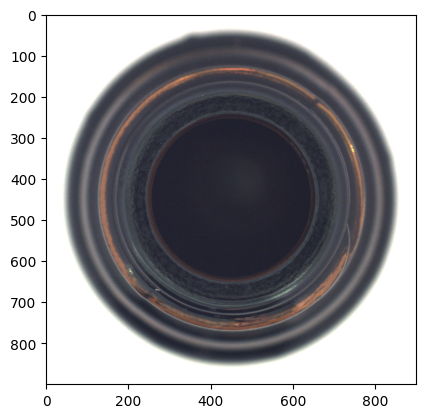

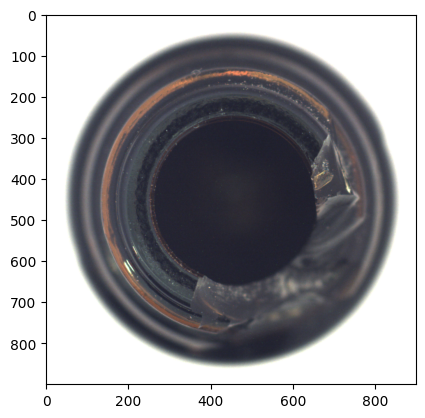

In [4]:
with PIL.Image.open("./data/bottle/train/good/000.png") as _im:
  matplotlib.pyplot.imshow(_im)
  matplotlib.pyplot.show()
with PIL.Image.open("./data/bottle/test/broken_large/000.png") as _im:
  matplotlib.pyplot.imshow(_im)
  matplotlib.pyplot.show()

## Setting up for data loading

In [59]:
class MVTecDataset(torch.utils.data.Dataset):
  def __init__(self, dataset_path, is_train, resize = 256):
    self.dataset_path = dataset_path
    self.resize = resize
    self.is_train = is_train
    self.test_folders = None

    self.transform_im = torchvision.transforms.Compose([
        torchvision.transforms.Resize(self.resize),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean = [0.5, 0.5, 0.5],
                                         std = [0.1, 0.1, 0.1])
    ])

    self.transform_mask = torchvision.transforms.Compose([
        torchvision.transforms.Resize(self.resize),
        torchvision.transforms.ToTensor()
    ])

    self._x, self._y, self._mask = self.initialize_data()
    self.len = len(self.x)

  def initialize_data(self):
    x = []
    y = []
    mask = []

    if not self.is_train:
      _ground_truth_dir = self.dataset_path.replace("test", "ground_truth")
      dirs = os.listdir(self.dataset_path)
      dirs.remove("good")
      for dir in dirs:
        for img in sorted(os.listdir(f"{self.dataset_path}/{dir}")):
          x.append(f"{self.dataset_path}/{dir}/{img}")
          y.append(1)
          mask.append(f"{_ground_truth_dir}/{dir}/{img}")

    for img in sorted(os.listdir(f"{self.dataset_path}/good")):
      x.append(f"{self.dataset_path}/good/{img}")
      y.append(0)
      mask.append(None)

    assert len(x) == len(y)
    return x, y, mask

  def __getitem__(self, idx):
    x = self._x[idx]
    y = self._y[idx]
    mask = self._mask[idx]

    x = PIL.Image.open(x).convert('RGB')
    x = self.transform_x(x)

    if y == 0:
      mask = torch.zeros([1, self.resize, self.resize])
    else:
      mask = PIL.Image.open(mask)
      mask = self.transform_make(mask)

    return x, y, mask

  def __len__(self):
    return self.len

## It's PADIM Time